In [1]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )

suppressPackageStartupMessages(library(coloc))

In [3]:
manifest = fread("pipeline/6.1.coloc_gwas/traits.manifest.txt", sep = "\t", header = TRUE, data.table = FALSE)
manifest = manifest[file.exists(manifest$filename) == TRUE,]


In [4]:
geneinfo_gene    = fread("pipeline/1.2.expression/gene_info.txt"   , sep = "\t", header = TRUE , data.table = FALSE)
geneinfo_isoform = fread("pipeline/1.2.expression/isoform_info.txt", sep = "\t", header = TRUE , data.table = FALSE)

In [5]:
run_eqtls_qsub = function(analysis_type, gene_ids)
{
    sh_file = paste(getwd(), "pipeline/6.1.coloc_gwas/script", paste("run.6.3", analysis_type, "sh", sep = "."), sep = "/")
    
    writeLines(text = c("#!/usr/bin/sh",
                        "source /frazer01/home/matteo/.bashrc",
                        paste("Rscript", paste(paste(getwd()       , "script", "6.3.run_coloc_gwas.R", sep = "/"),
                                               "--taskid"          , "$SGE_TASK_ID",
                                               "--analysis"        , analysis_type)
                             )
                       ), 
               con  = sh_file, 
               sep  = "\n\n")
    
    qsub_command = paste("qsub",
                         #"-l", "short",
                         "-t", paste(1, "-", nrow(gene_ids), ":1", sep = ""),
                         "-tc", 500, 
                         "-o" , paste(getwd(), paste("logs/coloc_gwas", analysis_type, "out", sep = "."), sep = "/"),
                         "-e" , paste(getwd(), paste("logs/coloc_gwas", analysis_type, "err", sep = "."), sep = "/"),
                         sh_file
                        )
    
    message(qsub_command)
    system(qsub_command)
}

run_eqtls_qsub("gene"   , geneinfo_gene   ) # run all genes
run_eqtls_qsub("isoform", geneinfo_isoform) # run all isoforms


qsub -t 1-20393:1 -tc 500 -o /frazer01/projects/CARDIPS/analysis/cardiac_eqtls/logs/coloc_gwas.gene.out -e /frazer01/projects/CARDIPS/analysis/cardiac_eqtls/logs/coloc_gwas.gene.err /frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/6.1.coloc_gwas/script/run.6.3.gene.sh

qsub -t 1-38271:1 -tc 500 -o /frazer01/projects/CARDIPS/analysis/cardiac_eqtls/logs/coloc_gwas.isoform.out -e /frazer01/projects/CARDIPS/analysis/cardiac_eqtls/logs/coloc_gwas.isoform.err /frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/6.1.coloc_gwas/script/run.6.3.isoform.sh



# PRIVATE:
- try to run an example

In [139]:
analysis = "gene"
gene_id  = "ENSG00000124588.20_5"
gwas     = "biomarkers-30680-both_sexes-irnt"
#gwas     = "categorical-6150-both_sexes-2"



In [140]:
if(analysis == "gene")
{
	geneinfo   = fread("pipeline/1.2.expression/gene_info.txt", sep = "\t", header = TRUE , data.table = FALSE)
	exp_folder = paste(getwd(), "pipeline", "1.2.expression", "tpm_gene", sep = "/")
	gt_folder  = paste(getwd(), "pipeline", "1.3.genotype"  , "tpm_gene", sep = "/")
	out_folder = paste(getwd(), "pipeline", "3.2.eqtls"     , "tpm_gene", sep = "/")
}
if(analysis == "isoform")
{
	geneinfo   = fread("pipeline/1.2.expression/isoform_info.txt", sep = "\t", header = TRUE , data.table = FALSE)
	exp_folder = paste(getwd(), "pipeline", "1.2.expression", "use_isoform", sep = "/")
	gt_folder  = paste(getwd(), "pipeline", "1.3.genotype"  , "use_isoform", sep = "/")
	out_folder = paste(getwd(), "pipeline", "3.2.eqtls"     , "use_isoform", sep = "/")
}

qtl_folder = paste(getwd(), "pipeline/3.2.eqtls"     , "eqtls_by_gene", paste("cardiac_eqtls", analysis, sep = "."), sep = "/")
out_folder = paste(getwd(), "pipeline/6.1.coloc_gwas",                  paste("coloc"        , analysis, sep = "."), sep = "/")

geneinfo = geneinfo[geneinfo$transcript_id == gene_id,]

In [144]:
eqtls      = fread(paste("pipeline", "3.2.eqtls", "eqtls", paste("cardiac_eqtls", analysis, "egenes.txt", sep = "."), sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
this_qtl   = eqtls[eqtls$transcript_id == gene_id & eqtls$egene == TRUE,]

#if(nrow(this_qtl) > 0)
#{

qtl_file   = paste(qtl_folder, paste("qtl", gene_id      , "txt", sep = "."), sep = "/")
tmp_file   = paste(out_folder, paste("TMP", gene_id, gwas, "txt", sep = "."), sep = "/")
gwas_file  = manifest[manifest$id == gwas, "filename"  ]
trait_type = manifest[manifest$id == gwas, "trait_type"]
n          = rowSums(manifest[manifest$id == gwas, c("n_cases_full_cohort_both_sexes", "n_controls_total")])
qtl_data   = fread(qtl_file, sep = "\t", header = TRUE, data.table = FALSE)
coord      = paste(sub("chr", "", geneinfo$chrom), ":", max(c(0, geneinfo$start - 500000)), "-", geneinfo$end + 500000, sep = "")
command    = paste("/frazer01/software/tabix-0.2.6/tabix", gwas_file, coord, ">", tmp_file)

system(command)

indata           = fread(tmp_file, sep = "\t", header = FALSE , data.table = FALSE)
myhead           = unlist(strsplit(system(paste("zcat", gwas_file, "|", "head", "-n", 1), intern = TRUE), split = "\t"))
colnames(indata) = myhead
indata  $idx     = paste(indata  $chr  , indata  $pos, sep = "_")
qtl_data$idx     = paste(qtl_data$chrom, qtl_data$pos, sep = "_")
totest           = merge(qtl_data, indata, by = "idx", suffixes = 1:2)
totest           = totest[ totest$pval_heterogeneity > 1e-6,]

type2coloc = "quant"


if(!trait_type %in% c("biomarkers", "continuous"))
{
    totest$af_meta = totest$af_controls_meta
    type2coloc     = "cc"
    cases_fr       = manifest[manifest$id == gwas, "n_cases_full_cohort_both_sexes"] / manifest[manifest$id == gwas, "n_controls_total"]
}

if(nrow(totest[totest$ref1 == totest$alt2 & totest$alt1 == totest$ref2,]) > 0)
{
    totest1 = totest[totest$ref1 == totest$ref2 & totest$alt1 == totest$alt2,]
    totest2 = totest[totest$ref1 == totest$alt2 & totest$alt1 == totest$ref2,]
    
    totest2$beta_meta =   - totest2$beta_meta
    totest2$af_meta   = 1 - totest2$af_meta
    
    totest = rbind(totest1, totest2)
}

totest  = totest[order(totest$pos1),]


In [145]:
type    = 0


In [160]:
outdata = as.data.frame(rbindlist(lapply(this_qtl$type, function(type)
{
    tocoloc = totest[totest$type == type,]

    if(trait_type %in% c("biomarkers", "continuous"))
    {
        coloc_mapped = coloc.abf(dataset1 = list(snp = tocoloc$id, pvalues = tocoloc$pval     , N = 966, MAF = tocoloc$af     , type = "quant"),
                                 dataset2 = list(snp = tocoloc$id, pvalues = tocoloc$pval_meta, N = n  , MAF = tocoloc$af_meta, type = "quant"))
    }else
    {
        coloc_mapped = coloc.abf(dataset1 = list(snp = tocoloc$id, pvalues = tocoloc$pval     , N = 966, MAF = tocoloc$af     , type = "quant"),
                                 dataset2 = list(snp = tocoloc$id, pvalues = tocoloc$pval_meta, N = n  , MAF = tocoloc$af_meta, type = "cc"   , s = cases_fr))
    }

    probs           = as.data.frame(t(coloc_mapped$summary))
    myres           = coloc_mapped$results
    myres           = myres[, c(which(colnames(myres) == "snp"), ncol(myres))]
    colnames(myres) = c("id", "pp_snp")
    myres           = merge(unique(qtl_data[,c("id", "chrom", "pos", "ref", "alt", "af")]), myres)
    myres           = cbind(data.frame(transcript_id = gene_id, type = type), myres)
    myres           = myres[order(myres$pp_snp, decreasing = TRUE), ]
    out             = cbind(probs, myres[1, ])

    fwrite(myres, paste(out_folder, paste(gene_id, gwas, type, "txt", sep = "."), sep = "/"), sep = "\t", col.names = TRUE, row.names = FALSE)
    
    return(out)
})), stringsAsFactors = FALSE)

PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 1.25e-17  8.56e-01  2.09e-18  1.43e-01  1.25e-03 
[1] "PP abf for shared variant: 0.125%"
PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
   0.4040    0.4330    0.0673    0.0720    0.0232 
[1] "PP abf for shared variant: 2.32%"
PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 1.08e-30  8.52e-01  1.80e-31  1.42e-01  6.50e-03 
[1] "PP abf for shared variant: 0.65%"
PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
  0.01110   0.84300   0.00184   0.14000   0.00388 
[1] "PP abf for shared variant: 0.388%"
PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 4.12e-15  8.55e-01  6.86e-16  1.42e-01  2.23e-03 
[1] "PP abf for shared variant: 0.223%"
PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
  0.01030   0.84500   0.00171   0.14100   0.00231 
[1] "PP abf for shared variant: 0.231%"


In [161]:
outdata

nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,transcript_id,type,id,chrom,pos,ref,alt,af,pp_snp
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
2923,1.253952e-17,0.8562249,2.087306e-18,0.14252439,0.001250678,ENSG00000124588.20_5,2,VAR_6_3010459_C_T,6,3010459,C,T,0.502,0.9994449
2923,4.044507e-01,0.4329657,6.732412e-02,0.07204747,0.023212040,ENSG00000124588.20_5,4,VAR_6_3494249_C_T,6,3494249,C,T,0.233,0.2244266
2923,1.078833e-30,0.8517331,1.795805e-31,0.14177144,0.006495506,ENSG00000124588.20_5,0,VAR_6_3000303_A_C,6,3000303,A,C,0.279,0.8376275
2923,1.106601e-02,0.8429037,1.842028e-03,0.14030433,0.003883964,ENSG00000124588.20_5,3,VAR_6_3001258_G_A,6,3001258,G,A,0.363,0.5241789
2923,4.121989e-15,0.8553825,6.861388e-16,0.14238319,0.002234284,ENSG00000124588.20_5,1,VAR_6_3006807_A_G,6,3006807,A,G,0.164,0.7644478
2923,1.025246e-02,0.8450665,1.706605e-03,0.14066592,0.002308510,ENSG00000124588.20_5,5,VAR_6_3014483_C_T,6,3014483,C,T,0.385,0.3878080


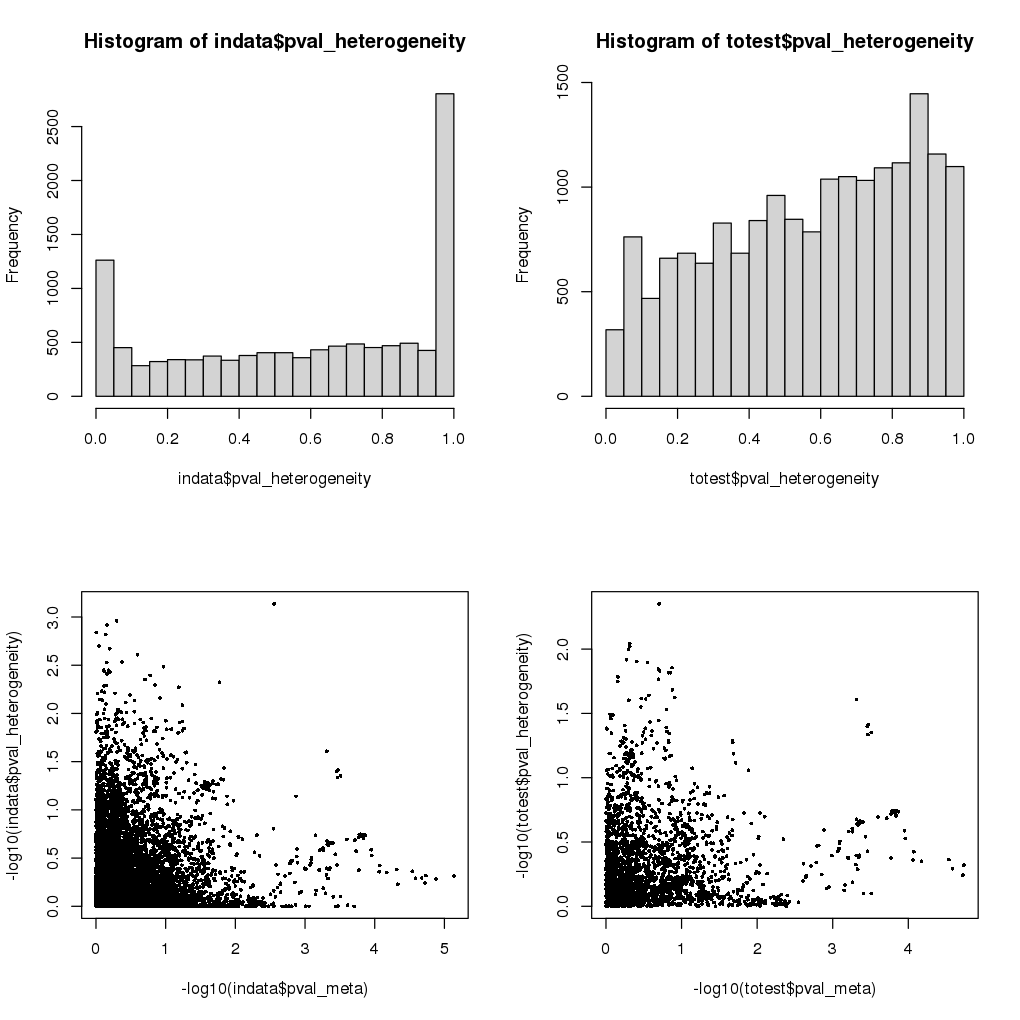

In [113]:
options(repr.plot.width = 8.5, repr.plot.height = 8.5)
layout(matrix(1:4, nrow = 2, byrow = TRUE))
hist(indata$pval_heterogeneity)
hist(totest$pval_heterogeneity)
plot(-log10(indata$pval_meta), -log10(indata$pval_heterogeneity), pch = 16, cex = 0.5)
plot(-log10(totest$pval_meta), -log10(totest$pval_heterogeneity), pch = 16, cex = 0.5)


In [165]:
message(paste("Rscript", "script/6.3.run_coloc_gwas.R", "--taskid", 1, "--analysis", "gene"))

Rscript script/6.3.run_coloc_gwas.R --taskid 1 --analysis gene



In [188]:
taskid = 1
analysis = "gene"

if(analysis == "gene")
{
	geneinfo   = fread("pipeline/1.2.expression/gene_info.txt", sep = "\t", header = TRUE , data.table = FALSE)
	exp_folder = paste(getwd(), "pipeline", "1.2.expression", "tpm_gene", sep = "/")
	gt_folder  = paste(getwd(), "pipeline", "1.3.genotype"  , "tpm_gene", sep = "/")
	out_folder = paste(getwd(), "pipeline", "3.2.eqtls"     , "tpm_gene", sep = "/")
}
if(analysis == "isoform")
{
	geneinfo   = fread("pipeline/1.2.expression/isoform_info.txt", sep = "\t", header = TRUE , data.table = FALSE)
	exp_folder = paste(getwd(), "pipeline", "1.2.expression", "use_isoform", sep = "/")
	gt_folder  = paste(getwd(), "pipeline", "1.3.genotype"  , "use_isoform", sep = "/")
	out_folder = paste(getwd(), "pipeline", "3.2.eqtls"     , "use_isoform", sep = "/")
}

rownames(geneinfo) = geneinfo$transcript_id

chromsizes  = read.table("/frazer01/reference/public/hg19/hg19.size.txt", sep = "\t", header = FALSE, col.names = c("chrom", "size"))[,1:2]
gene_id     = geneinfo[taskid, "transcript_id"]
gene_id     = "ENSG00000124588.20_5"
geneinfo    = geneinfo[geneinfo$transcript_id == gene_id,]
manifest    = fread("pipeline/6.1.coloc_gwas/traits.manifest.txt", sep = "\t", header = TRUE, data.table = FALSE)
manifest    = manifest[file.exists(manifest$filename) == TRUE,]
qtl_folder  = paste(getwd(), "pipeline/3.2.eqtls"     , "eqtls_by_gene", paste("cardiac_eqtls", analysis, sep = "."), sep = "/")
out_folder  = paste(getwd(), "pipeline/6.1.coloc_gwas",                  paste("coloc"        , analysis, sep = "."), sep = "/")
eqtls       = fread(paste("pipeline", "3.2.eqtls", "eqtls", paste("cardiac_eqtls", analysis, "egenes.txt", sep = "."), sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
this_qtl    = eqtls[eqtls$transcript_id == gene_id & eqtls$egene == TRUE,]

manifest = manifest[5:7,]


if(nrow(this_qtl) > 0)
{
	sink_outputs  = file(paste(out_folder, paste("TMP", gene_id, "sink", "output" , "txt", sep = "."), sep = "/"), open = "wt")
	sink(sink_outputs , type = "output")
	
	qtl_file   = paste(qtl_folder, paste("qtl", gene_id      , "txt", sep = "."), sep = "/")
	qtl_data   = fread(qtl_file, sep = "\t", header = TRUE, data.table = FALSE)
	coord      = paste(sub("chr", "", geneinfo$chrom), ":", max(c(0, geneinfo$start - 500000)), "-", geneinfo$end + 500000, sep = "")

	gwas_out    = lapply(manifest$id, function(gwas)
	{
		tmp_file   = paste(out_folder, paste("TMP", gene_id, gwas, "txt", sep = "."), sep = "/")
		gwas_file  = manifest[manifest$id == gwas, "filename"  ]
		trait_type = manifest[manifest$id == gwas, "trait_type"]
		n          = rowSums(manifest[manifest$id == gwas, c("n_cases_full_cohort_both_sexes", "n_controls_total")])
		command    = paste("tabix", gwas_file, coord, ">", tmp_file)
        command    = paste("/frazer01/software/tabix-0.2.6/tabix", gwas_file, coord, ">", tmp_file)


		system(command)
		
		if(file.size(tmp_file) > 0)
		{

			indata           = fread(tmp_file, sep = "\t", header = FALSE , data.table = FALSE)
			myhead           = unlist(strsplit(system(paste("zcat", gwas_file, "|", "head", "-n", 1), intern = TRUE), split = "\t"))
			colnames(indata) = myhead
			indata  $idx     = paste(indata  $chr  , indata  $pos, sep = "_")
			qtl_data$idx     = paste(qtl_data$chrom, qtl_data$pos, sep = "_")
			totest           = merge(qtl_data, indata, by = "idx", suffixes = 1:2)
			totest           = totest[ totest$pval_heterogeneity > 1e-6,]
			
			if(nrow(totest) > 0)
			{
				type2coloc       = "quant"

				if(!trait_type %in% c("biomarkers", "continuous"))
				{
					totest$af_meta = totest$af_controls_meta
					type2coloc     = "cc"
					cases_fr       = manifest[manifest$id == gwas, "n_cases_full_cohort_both_sexes"] / n
				}

				if(nrow(totest[totest$ref1 == totest$alt2 & totest$alt1 == totest$ref2,]) > 0)
				{
					totest1 = totest[totest$ref1 == totest$ref2 & totest$alt1 == totest$alt2,]
					totest2 = totest[totest$ref1 == totest$alt2 & totest$alt1 == totest$ref2,]
					
					totest2$beta_meta =   - totest2$beta_meta
					totest2$af_meta   = 1 - totest2$af_meta
					
					totest = rbind(totest1, totest2)
				}

				totest  = totest[order(totest$pos1),]
				outdata = lapply(this_qtl$type, function(type)
				{
					tocoloc = totest[totest$type == type,]
					
					if(trait_type %in% c("biomarkers", "continuous"))
					{
						coloc_mapped = coloc.abf(dataset1 = list(snp = tocoloc$id, pvalues = tocoloc$pval     , N = 966, MAF = tocoloc$af     , type = "quant"),
												 dataset2 = list(snp = tocoloc$id, pvalues = tocoloc$pval_meta, N = n  , MAF = tocoloc$af_meta, type = "quant"))
					}else
					{
						coloc_mapped = coloc.abf(dataset1 = list(snp = tocoloc$id, pvalues = tocoloc$pval     , N = 966, MAF = tocoloc$af     , type = "quant"),
												 dataset2 = list(snp = tocoloc$id, pvalues = tocoloc$pval_meta, N = n  , MAF = tocoloc$af_meta, type = "cc"   , s = cases_fr))
					}

					probs           = as.data.frame(t(coloc_mapped$summary))
					myres           = coloc_mapped$results
					myres           = myres[, c(which(colnames(myres) == "snp"), ncol(myres))]
					colnames(myres) = c("id", "pp_snp")
					myres           = merge(unique(qtl_data[,c("id", "chrom", "pos", "ref", "alt", "af")]), myres)
					myres           = cbind(data.frame(transcript_id = gene_id, type = type), myres)
					myres           = myres[order(myres$pp_snp, decreasing = TRUE), ]
					out             = cbind(probs, myres[1, ])
					out$trait       = gwas
					myres$trait     = gwas
					
					return(list(top = out, snp = myres))
				})
                
                outdata = list(top = as.data.frame(rbindlist(lapply(1:length(outdata), function(ii){outdata[[ii]][["top"]]})), stringsAsFactors = FALSE),
                               snp = as.data.frame(rbindlist(lapply(1:length(outdata), function(ii){outdata[[ii]][["snp"]]})), stringsAsFactors = FALSE)
                              )
                return(outdata)
			}else
			{
				out = data.frame(nsnps          = 0,
								 PP.H0.abf      = 1,
								 PP.H1.abf      = 0,
								 PP.H2.abf      = 0,
								 PP.H3.abf      = 0,
								 PP.H4.abf      = 0,
								 transcript_id  = gene_id, 
								 type           = this_qtl$type
								)
				out        = cbind(out, qtl_data[which.min(qtl_data$pval), c("id", "chrom", "pos", "ref", "alt", "af")])
				out$pp_snp = 0
				out$trait  = gwas
				myres      = data.frame(transcript_id  = gene_id, 
									    type           = this_qtl$type,
										id             = "",
										chrom          = "chr0",
										pos            = 0,
										ref            = "",
										alt            = "",
										af             = 0,
										pp_snp         = 0)

				outdata = list(top = out, snp = myres)
			}
		}else
		{
			out = data.frame(nsnps          = 0,
							 PP.H0.abf      = 1,
							 PP.H1.abf      = 0,
							 PP.H2.abf      = 0,
							 PP.H3.abf      = 0,
							 PP.H4.abf      = 0,
							 transcript_id  = gene_id, 
							 type           = this_qtl$type
							)
			out        = cbind(out, qtl_data[which.min(qtl_data$pval), c("id", "chrom", "pos", "ref", "alt", "af")])
			out$pp_snp = 0
			out$trait       = gwas
			
			myres      = data.frame(transcript_id  = gene_id, 
									type           = this_qtl$type,
									id             = "",
									chrom          = "chr0",
									pos            = 0,
									ref            = "",
									alt            = "",
									af             = 0,
									pp_snp         = 0)

			outdata = list(top = out, snp = myres)
		}
		
		return(outdata)
	})
	
	towrite_top = as.data.frame(rbindlist(lapply(1:length(gwas_out), function(ii){gwas_out[[ii]][["top"]]})), stringsAsFactors = FALSE)
	towrite_snp = as.data.frame(rbindlist(lapply(1:length(gwas_out), function(ii){gwas_out[[ii]][["snp"]]})), stringsAsFactors = FALSE)
	
	fwrite(towrite_top, paste(out_folder, paste("top", gene_id, "txt", sep = "."), sep = "/"), sep = "\t", col.names = TRUE, row.names = FALSE)
	fwrite(towrite_snp, paste(out_folder, paste("snp", gene_id, "txt", sep = "."), sep = "/"), sep = "\t", col.names = TRUE, row.names = FALSE)
	
	sink(type = "output")
	sink()
	
	system(paste("rm -r", paste(out_folder, paste("TMP", gene_id, sep = "."), "*", sep = "/")))
}


In [190]:
str(towrite_top)

'data.frame':	18 obs. of  16 variables:
 $ nsnps        : num  2908 2908 2908 2908 2908 ...
 $ PP.H0.abf    : num  1.01e-17 3.33e-01 8.79e-31 8.94e-03 3.34e-15 ...
 $ PP.H1.abf    : num  0.693 0.356 0.694 0.681 0.693 ...
 $ PP.H2.abf    : num  4.41e-18 1.45e-01 3.82e-31 3.88e-03 1.45e-15 ...
 $ PP.H3.abf    : num  0.301 0.155 0.301 0.296 0.301 ...
 $ PP.H4.abf    : num  0.00597 0.01167 0.00505 0.01012 0.00619 ...
 $ transcript_id: chr  "ENSG00000124588.20_5" "ENSG00000124588.20_5" "ENSG00000124588.20_5" "ENSG00000124588.20_5" ...
 $ type         : int  2 4 0 3 1 5 2 4 0 3 ...
 $ id           : chr  "VAR_6_3010459_C_T" "VAR_6_3001258_G_A" "VAR_6_3000303_A_C" "VAR_6_3001258_G_A" ...
 $ chrom        : int  6 6 6 6 6 6 6 6 6 6 ...
 $ pos          : int  3010459 3001258 3000303 3001258 3006807 3014483 3010459 3001258 3000303 3001258 ...
 $ ref          : chr  "C" "G" "A" "G" ...
 $ alt          : chr  "T" "A" "C" "A" ...
 $ af           : num  0.502 0.363 0.279 0.363 0.164 0.385 0.502 0.363

In [183]:
str(gwas_out)

List of 3
 $ :List of 6
  ..$ :List of 2
  .. ..$ top:'data.frame':	1 obs. of  16 variables:
  .. .. ..$ nsnps        : num 2908
  .. .. ..$ PP.H0.abf    : num 1.01e-17
  .. .. ..$ PP.H1.abf    : num 0.693
  .. .. ..$ PP.H2.abf    : num 4.41e-18
  .. .. ..$ PP.H3.abf    : num 0.301
  .. .. ..$ PP.H4.abf    : num 0.00597
  .. .. ..$ transcript_id: chr "ENSG00000124588.20_5"
  .. .. ..$ type         : int 2
  .. .. ..$ id           : chr "VAR_6_3010459_C_T"
  .. .. ..$ chrom        : int 6
  .. .. ..$ pos          : int 3010459
  .. .. ..$ ref          : chr "C"
  .. .. ..$ alt          : chr "T"
  .. .. ..$ af           : num 0.502
  .. .. ..$ pp_snp       : num 0.999
  .. .. ..$ trait        : chr "continuous-MAP-both_sexes-manual_irnt"
  .. ..$ snp:'data.frame':	2908 obs. of  10 variables:
  .. .. ..$ transcript_id: chr [1:2908] "ENSG00000124588.20_5" "ENSG00000124588.20_5" "ENSG00000124588.20_5" "ENSG00000124588.20_5" ...
  .. .. ..$ type         : int [1:2908] 2 2 2 2 2 2 2 2 2 2 ..